# Preparing for Model Evaluation

We will cover the following topics in this chapter:
- measuring accuracy, sensitivity, specificity, and precision for binary classification
- examining CAP, ROC, and precision-sensitivity curves for binary classification
- evaluating multiclass models
- evaluating regression models
- using k-fold cross-validation
- preprocessing data with pipelines

## Measuring accuracy, sensitivity, specificity, and precision for binary classification

Question:
> Is there a better way to understand accuracy, sensitivity, specificity, and precision in machine learning?

Answer from ChatGPT:


Yes, there are different ways to understand accuracy, sensitivity, specificity, and precision in machine learning. One useful way to understand these metrics is through their definitions and how they relate to the confusion matrix.

Accuracy: the proportion of correctly classified instances out of all instances in the dataset. It can be calculated as (TP + TN) / (TP + TN + FP + FN), where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives. Accuracy measures the overall performance of the model.

Sensitivity (also called recall or true positive rate): the proportion of actual positive instances that are correctly classified as positive. It can be calculated as TP / (TP + FN). Sensitivity measures how well the model identifies positive instances.

Specificity (also called true negative rate): the proportion of actual negative instances that are correctly classified as negative. It can be calculated as TN / (TN + FP). Specificity measures how well the model identifies negative instances.

Precision: the proportion of predicted positive instances that are actually positive. It can be calculated as TP / (TP + FP). Precision measures how accurate the model is in predicting positive instances.

Another useful way to understand these metrics is through examples and their interpretation in the context of a specific problem. For example, in a medical diagnosis problem, accuracy measures the overall performance of the model in correctly identifying patients with and without a certain disease. Sensitivity measures how well the model identifies patients with the disease, while specificity measures how well the model identifies patients without the disease. Precision measures how accurate the model is in identifying patients with the disease, and it may be more important than sensitivity if false positives have serious consequences, such as unnecessary treatments or surgeries.

It is important to consider all these metrics together and choose the appropriate one(s) based on the problem and the trade-offs between different types of errors. For example, in a problem where false positives are more costly than false negatives, it may be more important to optimize for precision than sensitivity.    


We can experiment with a __k-nearest neighbors (KNN)__ model to predict bachelor's degree attainment and evaluate its accuracy, sensitivity, specificity and precision.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data.load import load_nls97compba

In [7]:
nls97compba = load_nls97compba()
feature_cols = ["satverbal", "satmath", "gpaoverall", "parentincome", "gender"]
X_train, X_test, y_train, y_test = train_test_split(
    nls97compba[feature_cols],
    nls97compba[["completedba"]],
    test_size=0.3,
    random_state=0,
)

num_cols = feature_cols[:]
num_cols.remove("gender")
cat_cols = ["gender"]

num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop="first"))

transformer = ColumnTransformer(
    [("cat", cat_transformer, cat_cols), ("num", num_transformer, num_cols)],
    verbose_feature_names_out=False,
)
X_train_enc = pd.DataFrame(
    transformer.fit_transform(X_train),
    columns=transformer.get_feature_names_out(),
    index=X_train.index,
)
X_test_enc = pd.DataFrame(
    transformer.fit_transform(X_test),
    columns=transformer.get_feature_names_out(),
    index=X_test.index,
)

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_enc, y_train.values.ravel())
y_pred = knn.predict(X_test_enc)

[Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

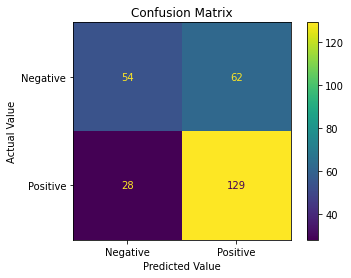

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
cmplot = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Negative", "Positive"]
)
cmplot.plot()
cmplot.ax_.set(
    title="Confusion Matrix", xlabel="Predicted Value", ylabel="Actual Value"
)

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test.values.ravel(), y_pred).ravel()
tn, fp, fn, tp

(54, 62, 28, 129)

In [27]:
print(classification_report(y_test.values.ravel(), y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55       116
         1.0       0.68      0.82      0.74       157

    accuracy                           0.67       273
   macro avg       0.67      0.64      0.64       273
weighted avg       0.67      0.67      0.66       273



In [32]:
accuracy_score(y_test.values.ravel(), y_pred)

0.6703296703296703

In [33]:
recall_score(y_test.values.ravel(), y_pred)

0.821656050955414

In [34]:
precision_score(y_test.values.ravel(), y_pred)

0.675392670157068

Just for comparison, let's try a random forest classifier and see if we get any better results.

In [37]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1, random_state=0)
rfc.fit(X_train_enc, y_train.values.ravel())
y_pred = rfc.predict(X_test_enc)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.40      0.52       116
         1.0       0.67      0.90      0.77       157

    accuracy                           0.68       273
   macro avg       0.71      0.65      0.64       273
weighted avg       0.70      0.68      0.66       273



^ The second model gets us significantly fewer false negatives and more true positives than the first model. The second model identifies actual positives 90% of the time, compared with 80% for the first model.

## Examining CAP, ROC, and precision-sensitivity curves for binary classification

There are several ways to _visualize the performance_ of a _binary classification model_. 

A relatively straightforward visualization is the __Cumulative Accuracy Profile (CAP)__, which shows the ability of our model to identify in-class, or positive, cases. It shows the cumulative cases on the X-axis and the cumulative positive outcomes on the Y-axis.

__Receiver operating characteristic (ROC)__ curves illustrates the tradeoff between model sensitivity (being able to identify positive values) and the false positive rate as we adjust the threshold for clasifying a postiive value.

Similarly, precision-sensitivity curves show the relationship between the reliability of our positive predictions (their precision) and sensitivity (our model's ability to identify positive actual values) as adjust the threshold.

### Constructing CAP curves

In [104]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data.load import load_nls97compba

In [50]:
nls97compba = load_nls97compba()
feature_cols = ["satverbal", "satmath", "gpaoverall", "parentincome", "gender"]
X_train, X_test, y_train, y_test = train_test_split(
    nls97compba[feature_cols], nls97compba["completedba"], test_size=0.3, random_state=0
)

num_cols = feature_cols[:]
num_cols.remove("gender")
cat_cols = ["gender"]

num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop="first"))

transformer = ColumnTransformer(
    [("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)],
    verbose_feature_names_out=False,
)

X_train_enc = pd.DataFrame(
    transformer.fit_transform(X_train),
    columns=transformer.get_feature_names_out(),
    index=X_train.index,
)
X_test_enc = pd.DataFrame(
    transformer.transform(X_test),
    columns=transformer.get_feature_names_out(),
    index=X_test.index,
)

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1, random_state=0)

We are now ready to start plotting our CAP curves.

1. draw a random model (this model use no information other than the overall distribution of positive values)
2. draw a perfect model (this model provides perfect information)

To draw the random model line:
1. count the number of observations in the test data and the number of positive values
2. use (0, 0) and (the number of observations, in-class count) to draw the random model line

To draw the perfect model line:
- plot a line from (0, 0) to (in-class count, in-class count) since that model can perfectly discriminate in-class values (it is never wrong)

In [53]:
num_obs = y_test.shape[0]
in_class_count = y_test.sum()
num_obs, in_class_count

(273, 157.0)

In [92]:
def plot_cap():
    plt.plot([0, num_obs], [0, in_class_count], c="b", label="Random model")
    plt.plot(
        [0, in_class_count, num_obs],
        [0, in_class_count, in_class_count],
        c="grey",
        linewidth=2,
        label="Perfect Model",
    )

    # We will also draw the vertical line at the midpoint and a horizontal line where that intersects the random model line.
    plt.axvline(num_obs / 2, color="black", linestyle="dashed", linewidth=1)
    plt.axhline(num_obs / 2, color="black", linestyle="dashed", linewidth=1)
    plt.title("Cumulative Accuracy Profile")
    plt.xlabel("Total Observations")
    plt.ylabel("In-Class Observations")
    plt.legend()

Next, we define a function to plot CPA curve for a model we pass to it. We will use the _predict proba_ method to get an array with the probability that each observation in the test data is in-class. 

Then, we will create a DataFrame with those probabilities and the actual target value, sort it by probability reverse order, and calculate a running total of positive actual target values. 

We will also get the value of the running total at the middle observation and draw a horizxontal line at that point. Finally, we will plot a line that has an array from 0 to the number of observations as x values, and the running in-class totals as y values:

In [88]:
def add_plot(model, X, X_test, y, model_name, linecolor):
    model.fit(X, y)
    probs = model.predict_proba(X_test)[:, 1]

    prob_df = pd.DataFrame(zip(probs, y_test), columns=["prob", "in_class"])
    prob_df.loc[-1] = 0.0
    prob_df = prob_df.sort_values(["prob", "in_class"], ascending=False).assign(
        in_class_cum=lambda x: x.in_class.cumsum()
    )

    in_class_midpoint = prob_df.iloc[int(prob_df.shape[0] / 2)].in_class_cum
    plt.axhline(in_class_midpoint, color=linecolor, linestyle="dashed", linewidth=1)
    plt.plot(
        np.arange(0, prob_df.shape[0]),
        prob_df.in_class_cum,
        c=linecolor,
        label=model_name,
        linewidth=4,
    )

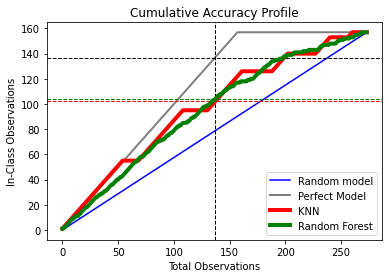

In [93]:
plot_cap()
add_plot(knn, X_train_enc, X_test_enc, y_train, "KNN", "red")
add_plot(rfc, X_train_enc, X_test_enc, y_train, "Random Forest", "green")
plt.legend()

^ The CAP curves show that our KNN and random forest models are better than randomly guessing, but not as good as a perfect model.

## Plotting a receiver operating characteristic (ROC) curve

ROC curves illustrate the tradeoff between the false positive rate and the true positive rate (also known as sensitivity) as we adjust the threshold. 

In [94]:
rfc.fit(X_train_enc, y_train)
y_pred = rfc.predict(X_test_enc)
pred_probs = rfc.predict_proba(X_test_enc)[:, 1]

In [98]:
prob_df = pd.DataFrame(
    zip(pred_probs, y_pred, y_test), columns=["prob", "pred", "actual"]
)
prob_df.groupby(["pred"])["prob"].agg(["min", "max"])

,min,max
pred,,
0.0,0.304114,0.498538
1.0,0.500760,0.883674


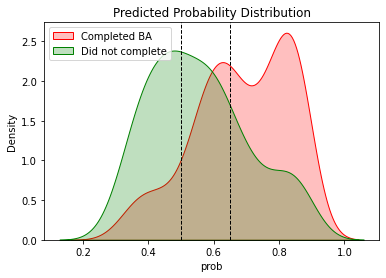

In [103]:
sb.kdeplot(
    prob_df.loc[prob_df.actual == 1].prob, shade=True, color="red", label="Completed BA"
)
sb.kdeplot(
    prob_df.loc[prob_df.actual == 0].prob,
    shade=True,
    color="green",
    label="Did not complete",
)
plt.axvline(0.5, color="black", linestyle="dashed", linewidth=1)
plt.axvline(0.65, color="black", linestyle="dashed", linewidth=1)
plt.title("Predicted Probability Distribution")
plt.legend(loc="upper left")

^ Here, we can see that our model has some trouble discriminating between actual positive and negative values since there is a fair bit of in-class and out-of-class overlap. 

A threshold of 0.5 gets us a lot of false positives since a good portion of the distribution of out-of-class observations (those not completing bachelor's degrees) have predicted probabilities greater than 0.5. If we mvoe the threhold higher, say to 0.65, we get many more false negatives since many in-class observations have probabilities lower than 0.65.

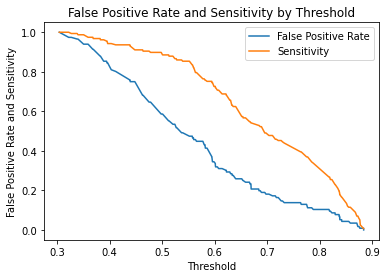

In [107]:
fpr, tpr, ths = roc_curve(y_test, pred_probs)
ths = ths[1:]
fpr = fpr[1:]
tpr = tpr[1:]
fig, ax = plt.subplots()
ax.plot(ths, fpr, label="False Positive Rate")
ax.plot(ths, tpr, label="Sensitivity")
ax.set(
    title="False Positive Rate and Sensitivity by Threshold",
    xlabel="Threshold",
    ylabel="False Positive Rate and Sensitivity",
)
ax.legend()

^ Increasing the threshold will improve (reduce) our false positive rate, but also lower our sensitivity.

[Text(0.5, 1.0, 'ROC curve'),
 Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'Sensitivity')]

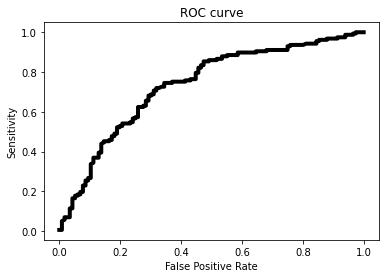

In [108]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, linewidth=4, color="black")
ax.set(title="ROC curve", xlabel="False Positive Rate", ylabel="Sensitivity")

## Plotting precision sensitivity curves

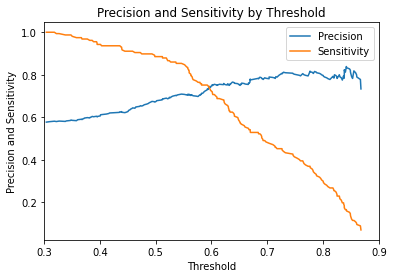

In [109]:
from sklearn.metrics import precision_recall_curve

prec, sens, ths = precision_recall_curve(y_test, pred_probs)

# We remove some squirreliness at the highest threshold values, which can sometimes happen.
prec = prec[1:-10]
sens = sens[1:-10]
ths = ths[:-10]

fig, ax = plt.subplots()
ax.plot(ths, prec, label="Precision")
ax.plot(ths, sens, label="Sensitivity")
ax.set(
    title="Precision and Sensitivity by Threshold",
    xlabel="Threshold",
    ylabel="Precision and Sensitivity",
    xlim=(0.3, 0.9),
)
ax.legend()

^ Here, we can see that sensitivity declines more steeply with thresholds above 0.5. This decline does not buy us much improved precision beyond the 0.6 threshold.

([<matplotlib.axis.YTick at 0x127caaaf0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

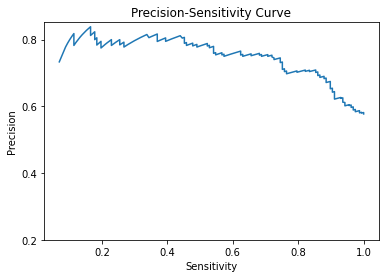

In [110]:
fix, ax = plt.subplots()
ax.plot(sens, prec)
ax.set(title="Precision-Sensitivity Curve", xlabel="Sensitivity", ylabel="Precision")
plt.yticks(np.arange(0.2, 0.9, 0.2))

^ The precision-sensitivity curve reflects the fact that sensitivity is much more responsive to threshold than is precision with this particular model. This means that we could decrease the threshold below 0.5 to get greater sensitivity, without a significant reduction in precision.

## Evaluating multiclass models


All of the same principles that we used to evaluate binary classification models apply to multiclass model evaluation.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data.load import load_nls97degreelevel

In [4]:
nls97degreelevel = load_nls97degreelevel()
feature_cols = ["satverbal", "satmath", "gpaoverall", "parentincome", "gender"]
X_train, X_test, y_train, y_test = train_test_split(
    nls97degreelevel[feature_cols],
    nls97degreelevel["degreelevel"],
    test_size=0.3,
    random_state=0,
)

num_cols = feature_cols[:]
num_cols.remove("gender")
cat_cols = ["gender"]

num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop="first"))

transformer = ColumnTransformer(
    [("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)],
    verbose_feature_names_out=False,
)

transformer.fit(X_train)

X_train_enc = pd.DataFrame(
    transformer.transform(X_train),
    columns=transformer.get_feature_names_out(),
    index=X_train.index,
)
X_test_enc = pd.DataFrame(
    transformer.transform(X_test),
    columns=transformer.get_feature_names_out(),
    index=X_test.index,
)

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_enc, y_train)

y_pred = knn.predict(X_test_enc)
pred_probs = knn.predict_proba(X_test_enc)

[Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

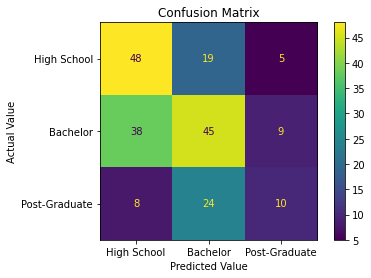

In [7]:
cm = confusion_matrix(y_test, y_pred)
cmplot = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["High School", "Bachelor", "Post-Graduate"]
)
cmplot.plot()

cmplot.ax_.set(
    title="Confusion Matrix", xlabel="Predicted Value", ylabel="Actual Value"
)

In [9]:
print(
    classification_report(
        y_test, y_pred, target_names=["High School", "Bachelor", "Post-Graduate"]
    )
)

               precision    recall  f1-score   support

  High School       0.51      0.67      0.58        72
     Bachelor       0.51      0.49      0.50        92
Post-Graduate       0.42      0.24      0.30        42

     accuracy                           0.50       206
    macro avg       0.48      0.46      0.46       206
 weighted avg       0.49      0.50      0.49       206



## Evaluating regression models

Metrics for regression evaluation are typically based on the distance between the actual values for the target variable andd a model's predicted values.

The most common measures - mean squared error, root mean squared error, mean absolute error, and R-squared - all track how successfully our predictions capture variation in a target.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from data.load import load_landtemps2019avgs

In [28]:
land_temps = load_landtemps2019avgs()
feature_cols = ["latabs", "elevation"]

X_train, X_test, y_train, y_test = train_test_split(
    land_temps[feature_cols], land_temps[["avgtemp"]], test_size=0.3, random_state=0
)

In [30]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train), columns=feature_cols, index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test), columns=feature_cols, index=X_test.index
)

scaler.fit(y_train)
y_train = pd.DataFrame(
    scaler.transform(y_train), columns=["avgtemp"], index=y_train.index
)
y_test = pd.DataFrame(scaler.transform(y_test), columns=["avgtemp"], index=y_test.index)

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
np.column_stack((lr.coef_.ravel(), X_test.columns.values))

array([[-0.8538957537748765, 'latabs'],
       [-0.3058979822791852, 'elevation']], dtype=object)

In [32]:
list(zip(lr.coef_.ravel(), X_test.columns))

[(-0.8538957537748765, 'latabs'), (-0.3058979822791852, 'elevation')]

^ The interpretation of the `latabs` coefficient is that standardized average annual temperature will decline by 0.85 for every one standard deviation increase in latitude. 

In [33]:
y_pred = lr.predict(X_test)
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.avgtemp - pred_df.prediction

In [34]:
pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean       -0.021225
median      0.032435
skew       -0.640720
kurtosis    6.815607
Name: resid, dtype: float64

Text(0, 0.5, 'Frequency')

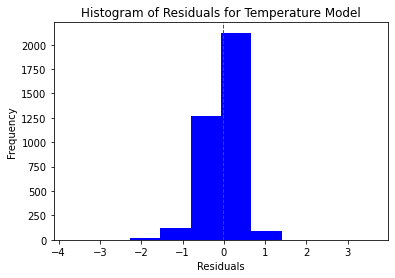

In [35]:
plt.hist(pred_df.resid, color="blue")
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residuals for Temperature Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

Text(0, 0.5, 'Residuals')

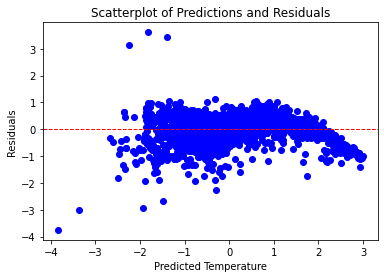

In [36]:
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Temperature")
plt.ylabel("Residuals")

^ The residuals hover somewhat randomly around 0. However, predictions between 1 and 2 standard deviations are much more likely to be too low (to have positive residuals) than too high. Above 2, the predictions are always too high (they have negative residuals). The model's assumption of linearity might not be sound.

In [37]:
mse = mean_squared_error(y_test, y_pred)
mse

0.18906346144036684

In [38]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.4348142838504352

In [39]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.31830737972814294

In [40]:
r2 = r2_score(y_test, y_pred)
r2

0.8162525715296725

^ An MSE of less than 0.2 of a standard deviation and an MAE of less than 0.3 for a standard deviation looks pretty decent, especially for such a sparse model. An R-squared above 80% is also fairly promising.

Let's see what we get if we used KNN model instead.

In [42]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [43]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.25021894417376683

In [45]:
r2 = r2_score(y_test, y_pred)
r2

0.8630964548192819

^ This model is actually an improvement in both MAE and R-squared.

Text(0, 0.5, 'Residuals')

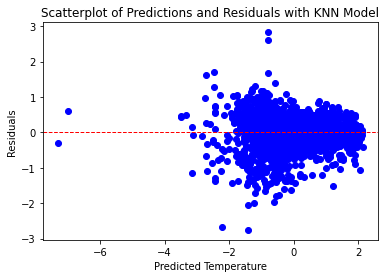

In [46]:
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.avgtemp - pred_df.prediction
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals with KNN Model")
plt.xlabel("Predicted Temperature")
plt.ylabel("Residuals")

^ This plot of residuals looks better as well. There are no parts of the target's distribution where we are much more likely to over-predict or under-predict.

## Using K-fold cross-validation

In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from data.load import load_landtemps2019avgs

In [51]:
land_temps = load_landtemps2019avgs()
feature_cols = ["latabs", "elevation"]

X_train, X_test, y_train, y_test = train_test_split(
    land_temps[feature_cols], land_temps["avgtemp"], test_size=0.1, random_state=0
)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [53]:
def get_scores(model):
    pipeline = make_pipeline(StandardScaler(), model)
    score = cross_validate(
        pipeline, X=X_train, y=y_train, cv=kf, scoring=["r2"], n_jobs=1
    )
    scores.append(
        dict(
            model=str(model),
            fit_time=score["fit_time"].mean(),
            r2=score["test_r2"].mean(),
        )
    )

In [54]:
scores = []
get_scores(LinearRegression())
get_scores(RandomForestRegressor(max_depth=2))
get_scores(KNeighborsRegressor(n_neighbors=5))
scores

[{'model': 'LinearRegression()',
  'fit_time': 0.015121698379516602,
  'r2': 0.8181125031214872},
 {'model': 'RandomForestRegressor(max_depth=2)',
  'fit_time': 0.40967597961425783,
  'r2': 0.7127731800138487},
 {'model': 'KNeighborsRegressor()',
  'fit_time': 0.006464862823486328,
  'r2': 0.8686757374391106}]

^ The KNN regressor model performs better than either the linear regression or random forest regression model, based on R-squared. The random forest regressor also has a significant advantage in that it has a much longer fit time. 

## Preprocessing data with pipelines